### Задание

- Выполнить предсказание временного ряда.  
- Разделить нужно не смешивая прошлое и будущее.   
- Использовать sarima /  Prophet?  
- docker / собрать контейнер с tf + добавить свои данные  
- Electric_Production  

### Анализ
Построоим 2 модели предсказаний. Первую на основе библиотеки Prophet, а вторую на основе рекуррентных нейронных сетей

### Имплементация
Модель на основе prophet

01:36:24 - cmdstanpy - INFO - Chain [1] start processing
01:36:24 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.501574868207621
MSE: 11.507812758736277
RMSE: 3.3923167244136088
R²: 0.8757824492572247


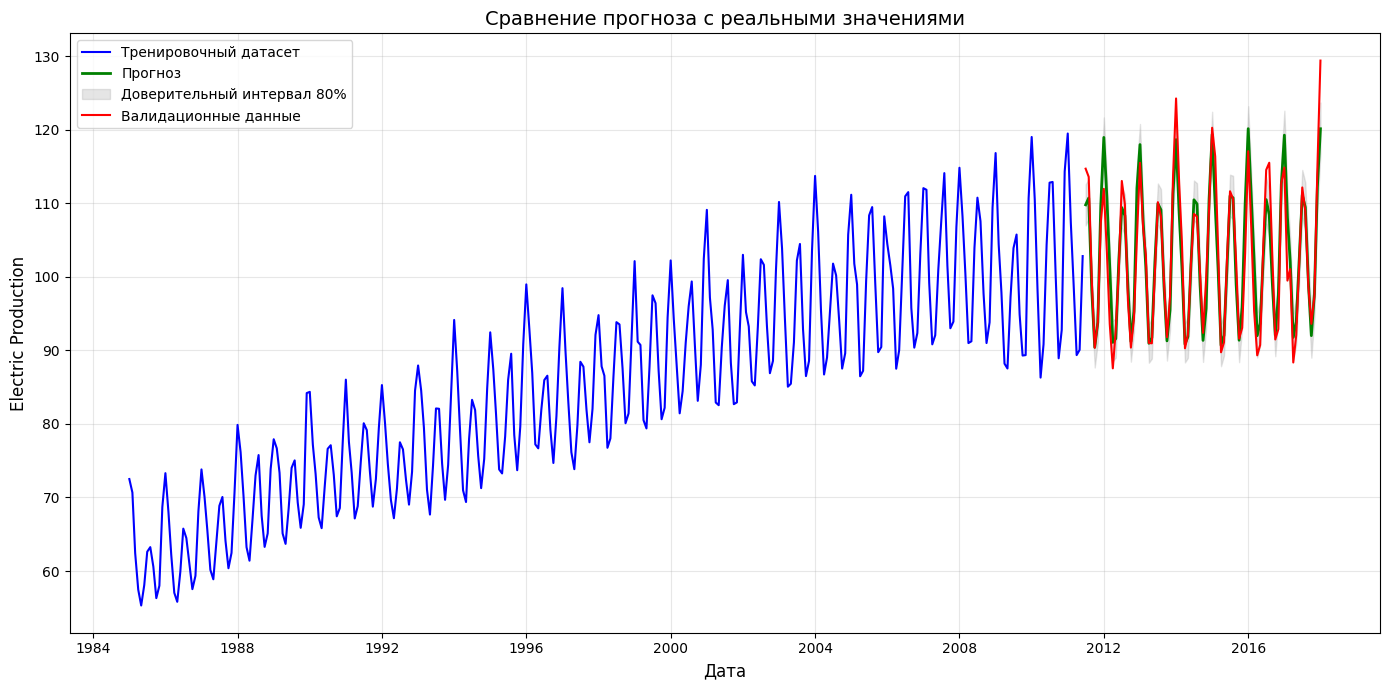

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


df = pd.read_csv('Electric_Production.csv', parse_dates=[0])
df.columns = ['ds', 'y']

test_size = int(len(df) * 0.2)
train = df[:-test_size]
valid = df[-test_size:]

model = Prophet(
    changepoint_prior_scale=0.1,  
    seasonality_prior_scale=8.25,    
    changepoint_range=1,        
    yearly_seasonality='auto',      
    weekly_seasonality=False,       
    daily_seasonality=False,
    seasonality_mode='multiplicative'
).add_seasonality(
    name='biannual',
    period=181.17196886724338,
    prior_scale=11.41549279677867,
    fourier_order=7
)

model.fit(train)

future = model.make_future_dataframe(periods=test_size, freq='ME')
forecast = model.predict(valid)
preds = forecast['yhat']

print(f'MAE: {mean_absolute_error(valid["y"], preds)}')
print(f'MSE: {mean_squared_error(valid["y"], preds)}')
print(f'RMSE: {np.sqrt(mean_squared_error(valid["y"], preds))}')
print(f'R²: {r2_score(valid["y"], preds)}')

plt.figure(figsize=(14, 7))

plt.plot(train['ds'], train['y'], 'b-', label='Тренировочный датасет')

plt.plot(forecast['ds'], forecast['yhat'], 'g-', linewidth=2, label='Прогноз')
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='gray',
    alpha=0.2,
    label='Доверительный интервал 80%'
)

plt.plot(
    valid['ds'], 
    valid['y'], 
    color='red', 
    label='Валидационные данные'
)

plt.title('Сравнение прогноза с реальными значениями', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Electric Production', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Модель на основе рекуррентных нейронных сетей

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 512)            │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,121 (4.08 MB)

 Trainable params: 1,069,121 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
MAE: 2.946242147046283
MSE: 14.382114792703623
RMSE: 3.7923758770332383
R²: 0.8317336871085151


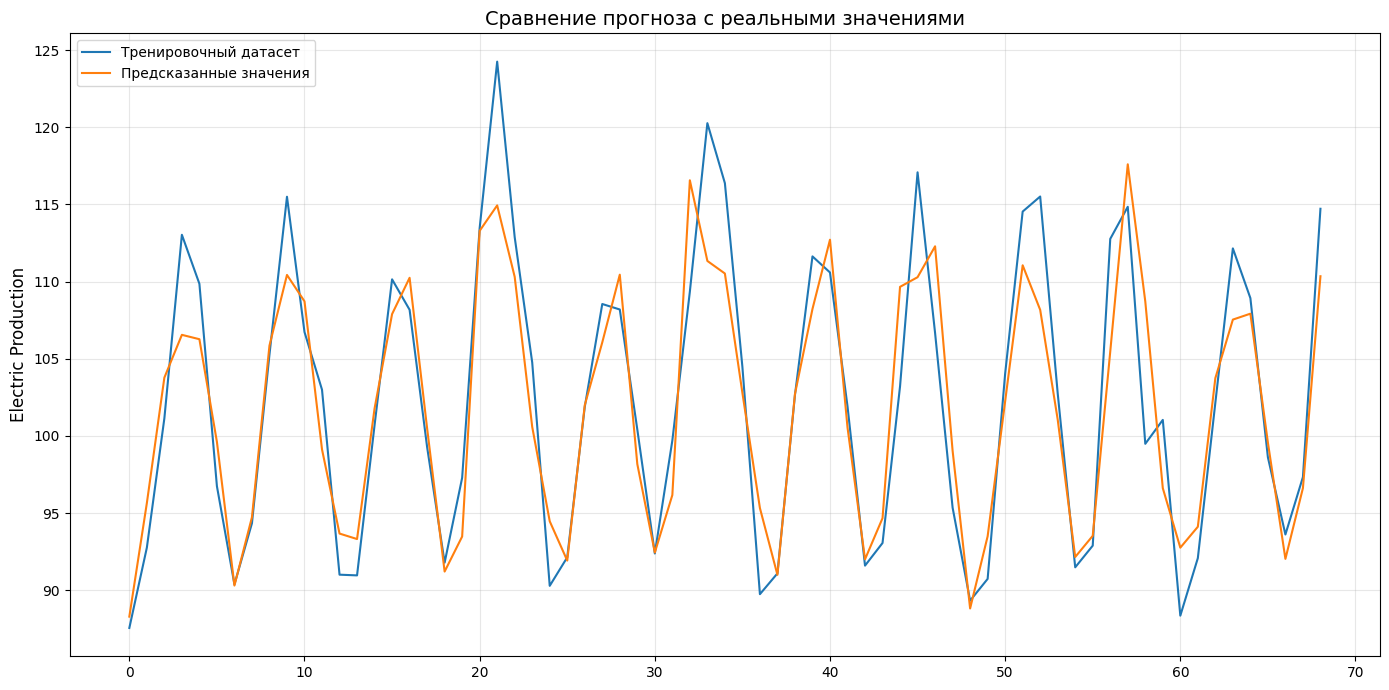

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, InputLayer, LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

dataframe = read_csv('Electric_Production.csv', usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def to_sequences(dataset, seq_size=1):
    x = []
    y = []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
    return np.array(x), np.array(y)

seq_size = 10
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

layers = [
    InputLayer(shape=(seq_size, 1)),
    LSTM(512),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='linear')
]

model = Sequential(layers)

model.compile(
    optimizer=Adam(),
    loss='mean_squared_error',
    metrics=['mae']
)

model.summary()

model.fit(trainX, trainY, verbose=0, epochs=250)

testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

print(f'MAE: {mean_absolute_error(testY[0], testPredict[:,0])}')
print(f'MSE: {mean_squared_error(testY[0], testPredict[:,0])}')
print(f'RMSE: {np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))}')
print(f'R²: {r2_score(testY[0], testPredict[:,0])}')

plt.figure(figsize=(14, 7))
plt.plot(testY[0], label='Тренировочный датасет')
plt.plot(testPredict[:,0], label='Предсказанные значения')
plt.title('Сравнение прогноза с реальными значениями', fontsize=14)
plt.ylabel('Electric Production', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Выводы

1. **Prophet (Facebook)**:  
   Построена прогнозная модель с использованием библиотеки Prophet. Для улучшения точности:
   - Добавлена пользовательская сезонность с периодом 6 месяцев
   - Оптимизированы гиперпараметры сезонных компонентов  
   Модель демонстрирует высокое качество (R² = 0.876) и хорошую сходимость с валидационной выборкой. Основные преимущества - интерпретируемость результатов и автоматическая обработка пропусков.

2. **LSTM-сети**:  
   Реализована нейросетевая архитектура на основе Long Short-Term Memory:
   - Базовая однослойная конфигурация показала R² = 0.832
   - Эксперименты с добавлением второго LSTM-слоя, пакетной нормализации и дропаута (dropout=0.2) не дали значимого улучшения. Ограничением выступил малый объем данных, что повышает риск переобучения при усложнении модели.

3. **Вейвлет-анализ**:  
   Потенциально, модели, основанные на вейвлетном анализе, смогли бы дать более высокие метрики. Визуально данные хорошо описываются MHAT-вейвлетом.